# Probabilistic Mission Design - Quick Start

In [1]:
# The imports we will need to run Probabilistic Mission Design
from promis import ProMis, StaRMap
from promis.geo import PolarLocation, CartesianMap, CartesianLocation, CartesianRasterBand, CartesianCollection
from promis.loaders import OsmLoader
from numpy import eye
import matplotlib.pyplot as plt

In [2]:
# The features we will load from OpenStreetMap
# The dictionary key will be stored as the respective features location_type
# The dictionary value will be used to query the relevant geometry via Overpass
feature_description = {
    "park": "['leisure' = 'park']",
    "primary": "['highway' = 'primary']",
    "secondary": "['highway' = 'secondary']",
    "tertiary": "['highway' = 'tertiary']",
    "service": "['highway' = 'service']",
    "crossing": "['footway' = 'crossing']",
    "bay": "['natural' = 'bay']",
    "rail": "['railway' = 'rail']",
}

# Covariance matrices for some of the features
# Used to draw random translations representing uncertainty for the respective features
covariance = {
    "primary": 15 * eye(2),
    "secondary": 10 * eye(2),
    "tertiary": 5 * eye(2),
    "service": 2.5 * eye(2),
    "operator": 20 * eye(2),
}

# The probabilistic, logical constraints to fulfill during a mission
logic = """
    % UAV properties
    initial_charge ~ normal(90, 5).
    charge_cost ~ normal(-0.1, 0.2).
    weight ~ normal(0.2, 0.1).

    % Weather conditions
    1/10::fog; 9/10::clear.

    % Visual line of sight
    vlos(X) :- 
        fog, distance(X, operator) < 50;
        clear, distance(X, operator) < 100;
        clear, over(X, bay), distance(X, operator) < 400.

    % Sufficient charge to return to operator
    can_return(X) :-
        B is initial_charge, O is charge_cost,
        D is distance(X, operator), 0 < B + (2 * O * D).

    % Permits related to local features
    permits(X) :- 
        distance(X, service) < 15; distance(X, primary) < 15;
        distance(X, secondary) < 10; distance(X, tertiary) < 5;
        distance(X, crossing) < 5; distance(X, rail) < 5;
        over(X, park).

    % Definition of a valid mission
    landscape(X) :- 
        vlos(X), weight < 25, can_return(X); 
        permits(X), can_return(X).
"""

# The mission area, points that will be estimated from 25 samples and points that will be interpolated
origin = PolarLocation(latitude=49.878091, longitude=8.654052)
width, height = 1000.0, 1000.0
number_of_random_maps = 25
support = CartesianRasterBand(origin, (50, 50), width, height)  # This is the set of points that will be directly computed through sampling (expensive)
target = CartesianRasterBand(origin, (250, 250), width, height)  # This is the set of points that will be interpolated from the support set (cheap)
# alternative = CartesianCollection(origin, [CartesianLocation(42, 42)])  # Alternatively, arbitrary points can be set for either set

# Setting up the Uncertainty Annotated Map from OpenStreetMap data
uam = OsmLoader(origin, (width, height), feature_description).to_cartesian_map()
uam.features.append(CartesianLocation(0.0, 0.0, location_type="operator"))  # We can manually add additional features
uam.apply_covariance(covariance)  # Assigns the covariance matrices defined earlier
uam.save(f"data/uam.pkl")  # We can save and load these objects to avoid recomputation

# Setting up the probabilistic spatial relations from the map data
star_map = StaRMap(target, CartesianMap.load(f"data/uam.pkl"))
star_map.initialize(support, number_of_random_maps, logic)  # This estimates all spatial relations that are relevant to the given logic
# star_map.add_support_points(support, number_of_random_maps, ["distance"], ["primary"])  # Alternatively, we can estimate for specific relations
star_map.save(f"data/star_map.pkl")

# Solve the mission area with ProMis
promis = ProMis(StaRMap.load(f"data/star_map.pkl"))
landscape = promis.solve(support, logic, n_jobs=4, batch_size=1)
landscape.save(f"data/landscape.pkl")

/Volumes/Vault/Repositories/CoCo/promis/star_map.py:478: UserWarning: no features for relation "over" for location type "bay"
  warn(
/Volumes/Vault/Repositories/CoCo/promis/star_map.py:478: UserWarning: no features for relation "distance" for location type "rail"
  warn(


## Visualization

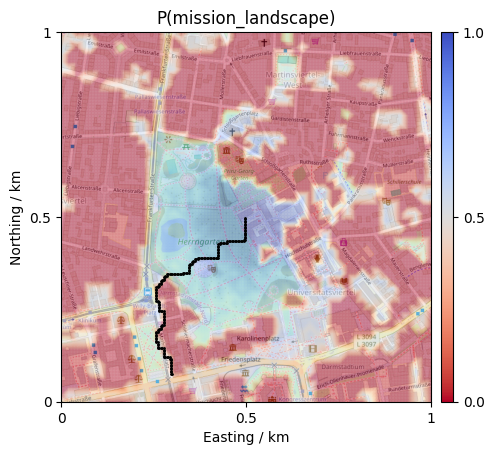

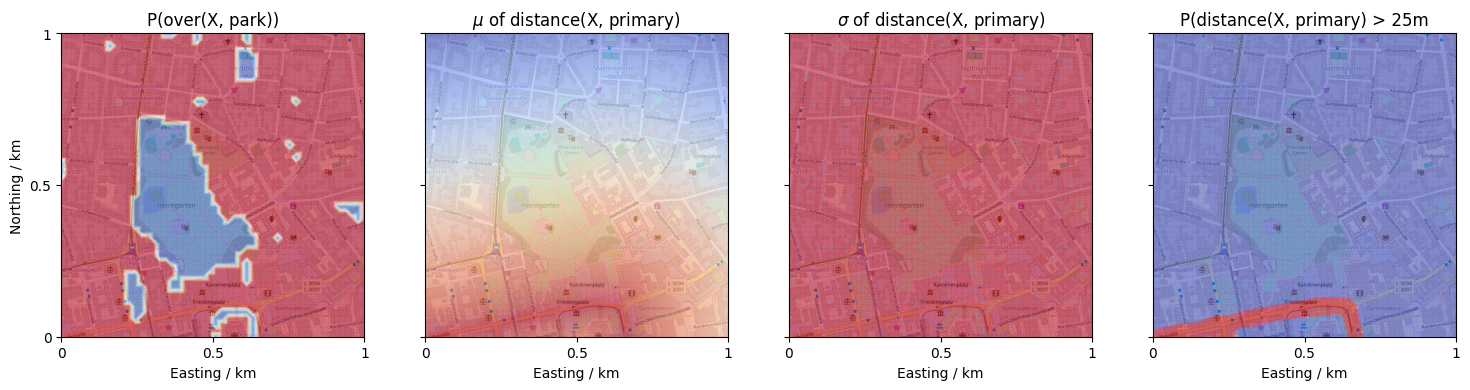

In [3]:
# ProMis' Collectiopn classes have a scatter method that can be used to render spatial relations or probabilistic mission landscapes
landscape = CartesianCollection.load(f"data/landscape.pkl")
image = landscape.scatter(s=0.4, plot_basemap=True, rasterized=True, cmap="coolwarm_r", alpha=0.25)
cbar = plt.colorbar(image, ticks=[0.0, 0.5, 1.0], aspect=30, pad=0.02)
cbar.ax.set_yticklabels(['0.0', '0.5', '1.0'])
cbar.solids.set(alpha=1)

# Plan a route from the center to the south east and overlay on the plot
start = (0.0, 0.0)
goal = (-200.0, -425.0)
path = landscape.search_path(start, goal, cost_model=lambda p: 1.0 - p, value_filter=lambda p: p > 0.2)
plt.scatter([n[0] for n in path], [n[1] for n in path], s=1, c='k')

# Setup plot style
ticks = [-500, 0, 500]
labels = ["0", "0.5", "1"]

plt.xlabel("Easting / km")
plt.ylabel("Northing / km")
plt.xticks(ticks, labels)
plt.yticks(ticks, labels)
plt.xlim([-500, 500])
plt.ylim([-500, 500])
plt.title("P(mission_landscape)")
plt.show()

# We can also retrieve and visualize StaR Map spatial relations in the same way
star_map = StaRMap.load("data/star_map.pkl")
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(18, 9))

axes[0].title.set_text('P(over(X, park))')
image = star_map.get("over", "park").parameters.scatter(ax=axes[0], s=0.4, plot_basemap=True, rasterized=True, cmap="coolwarm_r", alpha=0.25)

axes[1].title.set_text(r'$\mu$ of distance(X, primary)')
distance_primary = star_map.get("distance", "primary")
image = distance_primary.parameters.scatter(ax=axes[1], s=0.4, plot_basemap=True, rasterized=True, cmap="coolwarm_r", alpha=0.25)

axes[2].title.set_text(r'$\sigma$ of distance(X, primary)')
image = distance_primary.parameters.scatter(value_index=1, ax=axes[2], s=0.4, plot_basemap=True, rasterized=True, cmap="coolwarm_r", alpha=0.25)

axes[3].title.set_text(r'P(distance(X, primary) > 25m')
image = (distance_primary > 25).scatter(ax=axes[3], s=0.4, plot_basemap=True, rasterized=True, cmap="coolwarm_r", alpha=0.25)

axes[0].set_ylabel("Northing / km")
axes[0].set_yticks(ticks, labels)
axes[0].set_ylim([-500, 500])
for ax in axes:
    ax.set_xlabel("Easting / km")
    ax.set_xticks(ticks, labels)
    ax.set_xlim([-500, 500])

plt.show()